In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Drift time: z vs t in Theory
Assuming properties:
* d_as = 2.5mm = 0.25cm  #distance anode to LXe-surface
* d_sg = 2.5mm = 0.25cm  #distance LXe-surface to gate
* d_gc = 71.5mm = 7.15cm  #distance gate to cathode

* E_d = (U_cathode - U_gate) / len(tpc) ~= 35 kV / 70.25 mm ~= 4.98 kV/cm  # Drift-field strength
* E_g = (U_anode - U_gate) / (3 * 2.5mm) =(typical value)= 4.5 kV / (3* 0.25cm) = 6 kV/cm

In [2]:
def z_pos(t_drift, U_ca, U_ga, U_an):
    '''t: ns
    E: V/cm
    U: kV'''
    E_top, v_top, t_top_max, E_d, v_bot, _ = get_params(U_ca, U_ga, U_an)
    return [-v_top * t  # z [mm]
         if t <= t_top_max
         else -2.5 - (t - t_top_max) * v_bot # z [mm]
         for t in t_drift]

def z_naiv(t_drift, U_ca, U_ga, U_an):
    E_top, v_top, t_top_max, E_d, v_bot, _ = get_params(U_ca, U_ga, U_an)
    return [-v_bot * t  # z [mm]
         for t in t_drift]

def get_params(U_ca, U_ga, U_an):
    E_top = (U_an - U_ga) * 1000 / (3 * 0.25)  # V/cm
    v_top = 0.71 * E_top**0.15 / 1000 # mm/ns
    t_top_max = 2.5 / v_top # ns
    
    E_d = (U_ga - U_ca) * 1000 / 7.15   # V/cm
    v_bot =  0.71 * E_d**0.15 / 1000 # mm/ns
    
    t_max = -((-74 + 2.5) / (0.71 * E_d**0.15 / 1000) - (2.5 / (0.71 * E_top**0.15 / 1000)))
    
    return E_top, v_top, t_top_max, E_d, v_bot, t_max

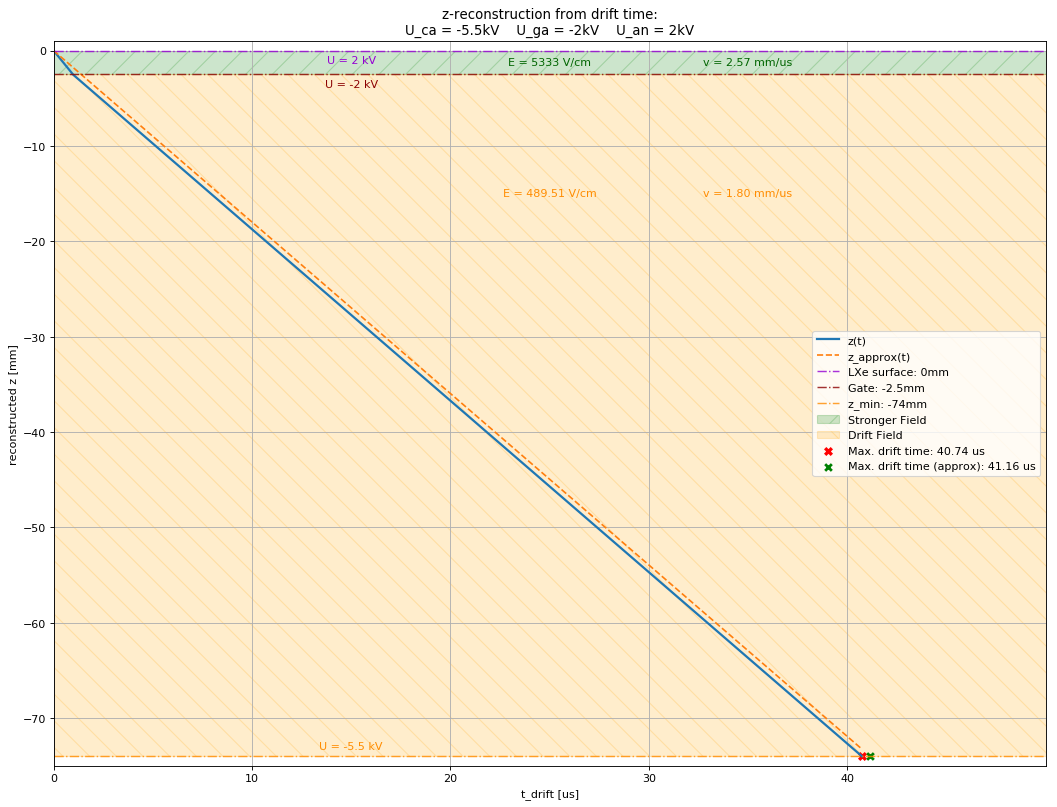

In [9]:
U_ca = -5.5
U_ga = -2
U_an = 2

E_top, v_top, t_top_max, E_d, v_bot, t_max = get_params(U_ca, U_ga, U_an)
round_t_max = round(t_max + 5_000, -4)

# plt.rcdefaults()
# plt.xkcd()

t_drift = np.linspace(0, t_max, 5000)
plt.figure(num=None, figsize=(8*2, 6*2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t_drift, z_pos(t_drift, U_ca, U_ga, U_an), linestyle='-', lw=2, label='z(t)')
plt.plot(t_drift, z_naiv(t_drift, U_ca, U_ga, U_an), linestyle='--', lw=1.5, label='z_approx(t)')
plt.title(f'z-reconstruction from drift time:\nU_ca = {U_ca}kV    U_ga = {U_ga}kV    U_an = {U_an}kV')
plt.xlabel('t_drift [us]')
plt.ylabel('reconstructed z [mm]')

plt.text(25_000, -2.5/2, f"E = {E_top:0.0f} V/cm", ha='center', va='center', color='darkgreen')
plt.text(25_000, -15, f"E = {E_d:0.2f} V/cm", ha='center', va='center', color='darkorange')
plt.text(35_000, -2.5/2, f"v = {v_top*1000:0.2f} mm/us", ha='center', va='center', color='darkgreen')
plt.text(35_000, -15, f"v = {v_bot*1000:0.2f} mm/us", ha='center', va='center', color='darkorange')

plt.text(15_000, -1, f"U = {U_an} kV", ha='center', va='center', color='darkviolet')
plt.text(15_000, -3.5, f"U = {U_ga} kV", ha='center', va='center', color='darkred')
plt.text(15_000, -73.5, f"U = {U_ca} kV", ha='center', va='bottom', color='darkorange')


lw, ls, alpha = 1.3, '-.', 0.8
plt.axhline(0, label='LXe surface: 0mm', c='darkviolet', linestyle=ls, alpha=alpha, linewidth=lw)
plt.axhline(-2.5, label='Gate: -2.5mm', c='darkred', linestyle=ls, alpha=alpha, linewidth=lw)
plt.axhline(-74, label='z_min: -74mm', c='darkorange', linestyle=ls, alpha=alpha, linewidth=lw)

plt.fill_between([0, round_t_max], [0]*2, [-2.5]*2, alpha=0.2, color='green', hatch='/', label='Stronger Field')
plt.fill_between([0, round_t_max], [-2.5]*2, [-74]*2, alpha=0.2, color='orange', hatch='\\', label='Drift Field')

plt.scatter([t_max], [-74], marker='x', linewidth=3, label=f'Max. drift time: {t_max/1000:0.2f} us', color='red')
plt.scatter([74/ (0.71 * E_d**0.15 / 1000)], [-74], marker='x', linewidth=2.5, label=f'Max. drift time (approx): {74/ (0.71 * E_d**0.15 / 1000)/1000:0.2f} us', color='green')

plt.legend()
plt.xticks([10_000 * i for i in range(int(round_t_max/10_000))], [10 * i for i in range(int(round_t_max/10_000))])
plt.ylim(-75, 1)
plt.xlim(0, round_t_max)
plt.grid()